# 2. Modeling 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import roc_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pprint
from tqdm.notebook import tqdm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import time

In [2]:
df = pd.read_pickle('dataset/train_fillna_max.pkl').rename({'order_quantity_bin':'TARGET'},axis=1)
# df = df[df.period>='2017-07'].reset_index()
train = df

In [3]:
df.head()

,period,part_id,order_quantity,TARGET,order_quantity_lag1,order_quantity_lag2,order_quantity_lag3,order_quantity_lag4,order_quantity_lag5,order_quantity_lag6,...,pcid_cluster,psid_binenc_1,psid_binenc_2,psid_binenc_3,psid_binenc_4,psid_binenc_5,cpcid,time_diff_mean,time,time_diff_std
0,2017-01,126,6.0,6.0,15.0,15.0,15.0,15.0,15.0,15.0,...,1,1,0,0,0,0,0,1.296296,1.0,0.608581
1,2017-01,134,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,...,1,1,0,0,0,0,0,1.346154,1.0,0.628796
2,2017-01,153,15.0,15.0,60.0,60.0,60.0,60.0,33.0,33.0,...,2,1,0,0,0,0,0,2.750000,1.0,2.050499
3,2017-01,174,15.0,15.0,30.0,30.0,30.0,30.0,30.0,30.0,...,2,1,0,0,0,0,0,2.461538,1.0,2.470337
4,2017-01,178,42.0,42.0,189.0,189.0,189.0,189.0,189.0,189.0,...,2,1,0,0,0,0,0,1.129032,1.0,0.427546


## 2.1. Separating Training & Test Data

In [4]:
feature_names = [e for e in df.columns if e not in ('period','part_id','TARGET','order_quantity')]

In [5]:
train_x = df[feature_names]
train_y = df['TARGET']

## 2.2. Feature Selection

### 2.2.1. Selecting Best Features

In [6]:
def plot_coefficients(coef, feature_names, top_features=20):
    top_positive_coefficients = np.argsort(coef)[-top_features:]
    top_negative_coefficients = np.argsort(coef)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coef[top_coefficients]]
    # print('2*top_features')
    # print(np.arange(2 * top_features))
    # print('coef[top_coefficients]')
    # print(coef[top_coefficients])
    # print('colors')
    # print(colors)
    plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
    plt.title('Feature Importances according to SVM Coefficients')
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.show()
    return feature_names[top_positive_coefficients],coef[top_positive_coefficients],feature_names[top_negative_coefficients],coef[top_negative_coefficients]

In [7]:
train_x_norm = np.empty(train_x.shape)
count = 0
for col in feature_names:
    x = np.array(train_x[col])
    x_norm = x / np.linalg.norm(x)
    train_x_norm[:,count] = x_norm
    count+=1

In [8]:
svm = LinearSVR(
          tol=0.0001,
          loss='squared_epsilon_insensitive',
          fit_intercept=True,
          intercept_scaling=1.0,
          dual=False,
          max_iter=1000)
svm.fit(train_x_norm, train_y)

LinearSVR(dual=False, loss='squared_epsilon_insensitive')

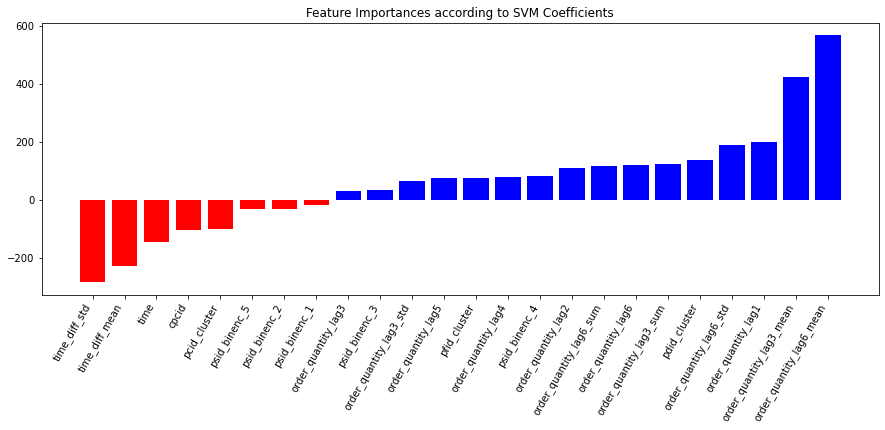

In [9]:
coef = svm.coef_
top_positive_features = []
top_negative_features = []

pnames, pcoef, nnames, ncoef = plot_coefficients(coef,feature_names,12)
top_positive_features.append((1,pnames,pcoef))
top_negative_features.append((1,nnames,ncoef))

In [10]:
importances_1 = pd.DataFrame([top_positive_features[0][1],top_positive_features[0][2]]).T
importances_1.columns = ['feature','coef_1_positive']
importances_positive = importances_1
importances_1 = pd.DataFrame([top_negative_features[0][1],top_negative_features[0][2]]).T
importances_1.columns = ['feature','coef_1_negative']
importances_negative = importances_1
importances = importances_positive.merge(importances_negative,how='outer',on='feature')
importances.set_index('feature',inplace=True)
importances['sum'] = importances.abs().sum(axis=1)
importances.sort_values('sum',ascending=False,inplace=True)
importances['rank'] = range(1,importances.shape[0]+1)
corr_matrix = train_x[importances.index.tolist()].corr().abs()

### 2.2.2. Dropping Highly Correlated Features

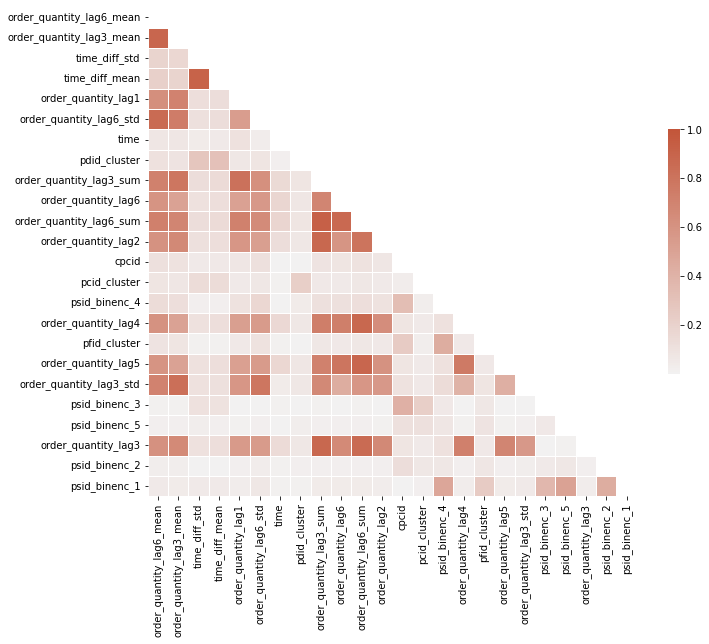

In [11]:
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=1, center=0.0,
            square=True, linewidths=.6, cbar_kws={"shrink": .5});

In [12]:
importances

,coef_1_positive,coef_1_negative,sum,rank
feature,,,,
order_quantity_lag6_mean,568.040763,NaN,568.040763,1
order_quantity_lag3_mean,424.614037,NaN,424.614037,2
time_diff_std,NaN,-283.788874,283.788874,3
time_diff_mean,NaN,-226.788269,226.788269,4
order_quantity_lag1,201.59948,NaN,201.599480,5
order_quantity_lag6_std,190.112138,NaN,190.112138,6
time,NaN,-143.575803,143.575803,7
pdid_cluster,138.709195,NaN,138.709195,8
order_quantity_lag3_sum,124.670558,NaN,124.670558,9


In [13]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop=[]
for col in upper.columns:
    tmp = upper.loc[col]>0.90
    compare_with = tmp[tmp==True].index.tolist()
    current_rank = importances.loc[col]['rank']
    if(len(compare_with)==0):
        continue
    else:
        print('current col: '+col+' current rank: '+str(current_rank))
        win=0
        print('starting to compare with: '+str(compare_with))
        for col2 in compare_with:
            print('col2: '+ col2+' col2.rank: '+str(importances.loc[col2]['rank']))
            if current_rank < importances.loc[col2]['rank']:
                to_drop+=[col2]
print('to_drop: ')
print(set(to_drop))

current col: time_diff_std current rank: 3
starting to compare with: ['time_diff_mean']
col2: time_diff_mean col2.rank: 4
current col: order_quantity_lag3_sum current rank: 9
starting to compare with: ['order_quantity_lag6_sum']
col2: order_quantity_lag6_sum col2.rank: 11
to_drop: 
{'order_quantity_lag6_sum', 'time_diff_mean'}


In [14]:
final_features = [e for e in feature_names if e not in set(to_drop)]

In [15]:
final_features

['order_quantity_lag1',
 'order_quantity_lag2',
 'order_quantity_lag3',
 'order_quantity_lag4',
 'order_quantity_lag5',
 'order_quantity_lag6',
 'order_quantity_lag3_mean',
 'order_quantity_lag3_std',
 'order_quantity_lag3_sum',
 'order_quantity_lag6_mean',
 'order_quantity_lag6_std',
 'pdid_cluster',
 'pfid_cluster',
 'pcid_cluster',
 'psid_binenc_1',
 'psid_binenc_2',
 'psid_binenc_3',
 'psid_binenc_4',
 'psid_binenc_5',
 'cpcid',
 'time',
 'time_diff_std']

## 2.3. Model Selection 

In [16]:
ix = {}
lag = 5
folds = 5
for fold in range(1,(1+folds)):
    train_till = (-1*lag*fold)
    valid_till = None if (-1*lag*(fold-1)) == 0 else (-1*lag*(fold-1))
    ix[fold] = {'train':df[df.period.isin(df.period.unique()[:train_till])].index,
                'valid':df[df.period.isin(df.period.unique()[train_till:valid_till])].index}

In [17]:
for k, v in ix.items():
    print(f"Fold: {k} ")
    print(f'Min-max train index: {v["train"].min(), v["train"].max()}, train.length: {len(v["train"])}')
    print(f'Min-max valid index: {v["valid"].min(), v["valid"].max()}, valid.length: {len(v["valid"])}')

Fold: 1 
Min-max train index: (0, 142058), train.length: 142059
Min-max valid index: (142059, 167058), valid.length: 25000
Fold: 2 
Min-max train index: (0, 117058), train.length: 117059
Min-max valid index: (117059, 142058), valid.length: 25000
Fold: 3 
Min-max train index: (0, 92108), train.length: 92109
Min-max valid index: (92109, 117058), valid.length: 24950
Fold: 4 
Min-max train index: (0, 67665), train.length: 67666
Min-max valid index: (67666, 92108), valid.length: 24443
Fold: 5 
Min-max train index: (0, 44216), train.length: 44217
Min-max valid index: (44217, 67665), valid.length: 23449


In [34]:
def run_kfold_model(df,model,model_name,final_features,fold_indexes,folds=[1,2,3]):
    results = {}
    for fold in tqdm(folds):
        print('='*5+' '+model_name+' - fold '+str(fold)+' '+'='*5)
        train = df.loc[fold_indexes[fold]['train']]
        valid = df.loc[fold_indexes[fold]['valid']]

        train_x = train[final_features]
        valid_x = valid[final_features]

        train_y = train['TARGET']
        valid_y = valid['TARGET']
        print('fitting model...')
        start_time = time.time()
#         model.fit(train_x, train_y, verbose=0, epochs=100)
        model.fit(train_x, train_y)
        ex_time = (time.time() - start_time)
        print('model fit!')
        train_y_pred = model.predict(train_x)
        print('predictions are made for train_x! 1')
        train_y_pred = np.ravel(train_y_pred)
        print('predictions are made for train_x! 2')
        valid_y_pred = np.ravel(model.predict(valid_x))
        print('predictions are made for valid_x!')
        results[fold] = {}
        results[fold]['metrics']={
            'rmse_train':mean_squared_error(train_y,train_y_pred, squared=False),
            'mae_train':mean_absolute_error(train_y,train_y_pred),
            'rmse_valid':mean_squared_error(valid_y,valid_y_pred, squared=False),
            'mae_valid':mean_absolute_error(valid_y,valid_y_pred)
        }
        results[fold]['preds'] = {
            'train_y_pred': train_y_pred,
            'valid_y_pred': valid_y_pred
        }
        results[fold]['execution_time'] = ex_time
        print(f"execution time: {ex_time}")
        pprint.pprint(results[fold])
    return results, model

### 2.3.1. K-Nearest Neighbor Regressor (KNN)

In [35]:
neighbors_list = [2,3,4,5,6,7,8,9,10,20]
neighbors_list = [10]

In [39]:
cumulative_model_results_knn = {}
for neighbor in neighbors_list:
    knn = KNeighborsRegressor(
        n_neighbors=neighbor,
        weights='uniform',
        algorithm='auto',
        leaf_size=30,
        p=2,
        metric='minkowski')
    results, knn = run_kfold_model(df,knn,'K-Nearest Neighbor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_knn[neighbor] = {'results':results,'model':knn}

  0%|          | 0/5 [00:00<?, ?it/s]

===== K-Nearest Neighbor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x! 1
predictions are made for train_x! 2
predictions are made for valid_x!
execution time: 0.02594780921936035
{'execution_time': 0.02594780921936035,
 'metrics': {'mae_train': 3.7795366713830156,
             'mae_valid': 3.763992,
             'rmse_train': 6.539186850794914,
             'rmse_valid': 6.756661246503334},
 'preds': {'train_y_pred': array([ 6. , 12. , 18. , ...,  4.2,  0.9,  9. ]),
           'valid_y_pred': array([3.6, 3.9, 7.5, ..., 6.6, 2.7, 7.8])}}
===== K-Nearest Neighbor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x! 1
predictions are made for train_x! 2
predictions are made for valid_x!
execution time: 0.03426098823547363
{'execution_time': 0.03426098823547363,
 'metrics': {'mae_train': 3.8660248250882034,
             'mae_valid': 3.7626,
             'rmse_train': 6.658145077498785,
             'rmse_valid': 6.6688098488410965},
 '

# 2.3.2. Random Forest (RF)

In [21]:
estimators_list = [10,20,30,40,50,60,70,80,90,100]
estimators_list = [100]

In [22]:
cumulative_model_results_rf = {}
for estimator in estimators_list:
    rf = RandomForestRegressor(
        n_estimators=estimator,
        criterion='mse',
        max_depth=7,
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_features='auto',
        max_leaf_nodes=45,
        min_impurity_decrease=0.0,
        bootstrap=True,);
    results, rf = run_kfold_model(df,rf,'Random Forest',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_rf[estimator] = {'results':results,'model':rf}

  0%|          | 0/5 [00:00<?, ?it/s]

===== Random Forest - fold 1 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 35.75456190109253
{'execution_time': 35.75456190109253,
 'metrics': {'mae_train': 3.986328795882262,
             'mae_valid': 3.6211753607146506,
             'rmse_train': 6.78984359214881,
             'rmse_valid': 6.460953977521895},
 'preds': {'train_y_pred': array([ 7.25696722,  7.34723356, 12.71026849, ...,  5.75456362,
        1.63303035,  9.66317096]),
           'valid_y_pred': array([ 8.06830232,  5.09397672,  4.89104932, ...,  5.412439  ,
        1.63303035, 11.66430265])}}
===== Random Forest - fold 2 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 28.011242151260376
{'execution_time': 28.011242151260376,
 'metrics': {'mae_train': 4.056887234713946,
             'mae_valid': 3.640328365699115,
             'rmse_train': 6.8751199626217865,
             'rmse_valid': 6.428387944053108},
 'preds': {'train_y_pred': array([ 7.1943286 ,  7.60937245, 13.57927305, ...,  6.53717958,
        1.52672106,  8.529744  ]),
           'valid_y_pred': array([5.44707097, 5.18079898, 6.39502579, ..., 5.80434397, 1.52672106,
       9.49020106])}}
===== Random Forest - fold 3 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 23.922597885131836
{'execution_time': 23.922597885131836,
 'metrics': {'mae_train': 4.170784586654945,
             'mae_valid': 3.7265855997396122,
             'rmse_train': 6.9991219058321095,
             'rmse_valid': 6.493004742543778},
 'preds': {'train_y_pred': array([ 7.22219384,  7.89020866, 14.87636869, ...,  6.49609103,
        3.23540543,  4.02011094]),
           'valid_y_pred': array([5.28669518, 4.2467114 , 1.80651639, ..., 6.40146172, 1.32780847,
       9.83130476])}}
===== Random Forest - fold 4 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 16.018661975860596
{'execution_time': 16.018661975860596,
 'metrics': {'mae_train': 4.2874264723016395,
             'mae_valid': 3.93024089781507,
             'rmse_train': 7.1259501849764915,
             'rmse_valid': 6.718385083874995},
 'preds': {'train_y_pred': array([ 7.12775835,  8.0796156 , 15.43586481, ...,  3.74664934,
        1.45727816,  2.24240795]),
           'valid_y_pred': array([5.7974047 , 5.20809196, 1.62962412, ..., 6.52046609, 3.02285291,
       4.37726518])}}
===== Random Forest - fold 5 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_forest.py:396: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 12.108272075653076
{'execution_time': 12.108272075653076,
 'metrics': {'mae_train': 4.44213671075157,
             'mae_valid': 4.194155892572585,
             'rmse_train': 7.279322399086052,
             'rmse_valid': 6.970221547934676},
 'preds': {'train_y_pred': array([ 7.463277  ,  8.74421382, 16.87972457, ...,  4.2471192 ,
        4.22833884,  4.1773997 ]),
           'valid_y_pred': array([4.86105431, 4.90289968, 2.04593219, ..., 4.23856454, 1.4600999 ,
       1.97116254])}}


### 2.3.3. Gradient Boosting (GB)

In [23]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
estimators_list = [1000]

In [24]:
cumulative_model_results_gb = {}
for estimator in estimators_list:
    gb = GradientBoostingRegressor(
        loss='ls',
        learning_rate=0.01,
        n_estimators=estimator,
        criterion='friedman_mse',
        min_samples_split=100,
        min_samples_leaf=40,
        min_weight_fraction_leaf=0.0,
        max_depth=7,
        min_impurity_decrease=0.0,
        alpha=0.9,
        verbose=0,
        max_leaf_nodes=45,
        n_iter_no_change=50,
        tol=0.0001,);
    results, gb = run_kfold_model(df,gb,'Gradient Boosting',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_gb[estimator] = {'results':results,'model':gb}

  0%|          | 0/5 [00:00<?, ?it/s]

===== Gradient Boosting - fold 1 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 450.5674831867218
{'execution_time': 450.5674831867218,
 'metrics': {'mae_train': 3.7504265502006664,
             'mae_valid': 3.608276825040775,
             'rmse_train': 6.168914534827315,
             'rmse_valid': 6.450601228717058},
 'preds': {'train_y_pred': array([ 8.19615965,  8.92816807, 16.73224658, ...,  5.98064945,
        1.3827261 ,  7.7112792 ]),
           'valid_y_pred': array([6.99040675, 4.50585073, 7.3286991 , ..., 5.39399982, 1.42865418,
       8.417214  ])}}
===== Gradient Boosting - fold 2 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 264.3388090133667
{'execution_time': 264.3388090133667,
 'metrics': {'mae_train': 3.8428347305019686,
             'mae_valid': 3.5274004581983194,
             'rmse_train': 6.329661263521528,
             'rmse_valid': 6.366032754290088},
 'preds': {'train_y_pred': array([ 7.77890135,  8.78660113, 14.05528169, ...,  5.30051391,
        1.14441282,  7.31261805]),
           'valid_y_pred': array([4.71257487, 4.22775341, 6.4866619 , ..., 5.66631933, 1.2730811 ,
       8.03841751])}}
===== Gradient Boosting - fold 3 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 274.79255199432373
{'execution_time': 274.79255199432373,
 'metrics': {'mae_train': 3.9088651130169207,
             'mae_valid': 3.5555786852853486,
             'rmse_train': 6.324630466548899,
             'rmse_valid': 6.415433211733748},
 'preds': {'train_y_pred': array([ 7.78025331,  9.48695109, 17.12958007, ...,  5.63471485,
        2.6657377 ,  4.5647978 ]),
           'valid_y_pred': array([4.7299917 , 4.08698556, 2.48592067, ..., 6.3339801 , 0.92147954,
       8.49998344])}}
===== Gradient Boosting - fold 4 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 60.499281883239746
{'execution_time': 60.499281883239746,
 'metrics': {'mae_train': 4.165184470815767,
             'mae_valid': 3.88147111986601,
             'rmse_train': 6.788323157932796,
             'rmse_valid': 6.666611419196223},
 'preds': {'train_y_pred': array([ 7.70724626,  8.88608693, 20.44340913, ...,  3.59613069,
        1.22858836,  2.03605835]),
           'valid_y_pred': array([5.89788608, 5.17834255, 2.33113972, ..., 6.28334221, 3.08159553,
       4.85378936])}}
===== Gradient Boosting - fold 5 =====
fitting model...


/Users/oguzhanakan/opt/anaconda3/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:286: FutureWarning: The loss 'ls' was deprecated in v1.0 and will be removed in version 1.2. Use 'squared_error' which is equivalent.
  warnings.warn(


model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 60.63784074783325
{'execution_time': 60.63784074783325,
 'metrics': {'mae_train': 4.243244483607051,
             'mae_valid': 4.138390737619067,
             'rmse_train': 6.796529150168485,
             'rmse_valid': 6.9192053841688566},
 'preds': {'train_y_pred': array([ 7.67835045,  9.11816116, 19.71446697, ...,  3.91070156,
        3.63312581,  3.466581  ]),
           'valid_y_pred': array([5.26737699, 5.05898052, 3.7284534 , ..., 3.86896013, 1.25982976,
       1.99586827])}}


# 3. Evaluation 

In [25]:
def get_metrics_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            dfs.append(pd.DataFrame.from_dict(tmp['results'][fold]['metrics'],orient='index',columns=['fold_'+str(fold)]))
        res[key] = pd.concat(dfs,axis=1)
    return res

## 3.1. Model Results

In [41]:
knn_results = get_metrics_from_results(cumulative_model_results_knn)[10]
knn_results['avg'] = knn_results.mean(axis=1)
knn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.539187,6.658145,6.794926,6.953361,7.155907,6.820305
mae_train,3.779537,3.866025,3.992672,4.117776,4.280786,4.007359
rmse_valid,6.756661,6.668810,6.755057,7.042023,7.310589,6.906628
mae_valid,3.763992,3.762600,3.767483,4.081438,4.405902,3.956283


In [42]:
knn_results.to_excel("knn-results.xlsx")

In [27]:
rf_results = get_metrics_from_results(cumulative_model_results_rf)[100]
rf_results['avg'] = rf_results.mean(axis=1)
rf_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.789844,6.875120,6.999122,7.125950,7.279322,7.013872
mae_train,3.986329,4.056887,4.170785,4.287426,4.442137,4.188713
rmse_valid,6.460954,6.428388,6.493005,6.718385,6.970222,6.614191
mae_valid,3.621175,3.640328,3.726586,3.930241,4.194156,3.822497


In [37]:
rf_results.to_excel("rf-results.xlsx")

In [28]:
gb_results = get_metrics_from_results(cumulative_model_results_gb)[1000]
gb_results['avg'] = gb_results.mean(axis=1)
gb_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.168915,6.329661,6.324630,6.788323,6.796529,6.481612
mae_train,3.750427,3.842835,3.908865,4.165184,4.243244,3.982111
rmse_valid,6.450601,6.366033,6.415433,6.666611,6.919205,6.563577
mae_valid,3.608277,3.527400,3.555579,3.881471,4.138391,3.742224


In [38]:
gb_results.to_excel("gb-results.xlsx")

## 3.2. Error Rate with Parameter Changes

### 3.2.1. KNN

In [ ]:
neighbors_list = [2,3,4,5,6,7,8,9,10,20]
x, y1, y2=[], [], []
for neighbor in neighbors_list:
    knn_results = get_metrics_from_results(cumulative_model_results_knn)[neighbor]
    knn_results['avg'] = knn_results.mean(axis=1)
    x.append(neighbor)
    y1.append(knn_results.loc['rmse_train'].avg)
    y2.append(knn_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['neighbors','rmse_train','rmse_valid']
re = re.melt(id_vars=['neighbors'])

fig = sns.lineplot(data=re,x='neighbors',y='value',hue='variable')
fig.set_xticks(neighbors_list);
fig.set_xticklabels(neighbors_list);
fig.set_title('Change in RMSE in increasing Neighbors (KNN)');

### 3.2.2. RF

In [ ]:
estimators_list = [10,20,30,40,50,60,70,80,90,100]
x, y1, y2=[], [], []
for estimator in estimators_list:
    rf_results = get_metrics_from_results(cumulative_model_results_rf)[estimator]
    rf_results['avg'] = rf_results.mean(axis=1)
    x.append(estimator)
    y1.append(rf_results.loc['rmse_train'].avg)
    y2.append(rf_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['estimators','rmse_train','rmse_valid']
re = re.melt(id_vars=['estimators'])

fig = sns.lineplot(data=re,x='estimators',y='value',hue='variable')
fig.set_xticks(estimators_list);
fig.set_xticklabels(estimators_list);
fig.set_title('Change in RMSE in increasing Estimators (RF)');

### 3.2.3. GB

In [25]:
estimators_list = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
x, y1, y2=[], [], []
for estimator in estimators_list:
    gb_results = get_metrics_from_results(cumulative_model_results_gb)[estimator]
    gb_results['avg'] = gb_results.mean(axis=1)
    x.append(estimator)
    y1.append(gb_results.loc['rmse_train'].avg)
    y2.append(gb_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['estimators','rmse_train','rmse_valid']
re = re.melt(id_vars=['estimators'])

fig = sns.lineplot(data=re,x='estimators',y='value',hue='variable')
fig.set_xticks(estimators_list);
fig.set_xticklabels(estimators_list);
fig.set_title('Change in RMSE in increasing Estimators (GB)');

KeyError: 100

## 3.3. Error Rate in Total Monthly Orders

In [153]:
df['period_str'] = df.period.astype(str)
monthly_orders = pd.DataFrame(df.groupby('period_str').TARGET.mean(),columns=['TARGET']).reset_index()

In [56]:
def get_monthly_orders_from_results(dct):
    res = {}
    for key in dct.keys():
        tmp = dct[key]
        dfs = []
        for fold in tmp['results'].keys():
            r = np.hstack((tmp['results'][fold]['preds']['train_y_pred'],tmp['results'][fold]['preds']['valid_y_pred']))
            dfs.append(r)
        res[key] = pd.DataFrame(dfs).T
    return res

In [177]:
monthly_orders_knn = get_monthly_orders_from_results(cumulative_model_results_knn)[10]
monthly_orders_knn['knn_pred'] = monthly_orders_knn.mean(axis=1)
monthly_orders_knn = pd.concat([df.period_str,monthly_orders_knn],axis=1)
# monthly_orders_knn = pd.DataFrame(monthly_orders_knn.groupby('period_str')['avg'].mean()).reset_index().rename({'avg':'order_quantity_knn'},axis=1)

In [178]:
monthly_orders_rf = get_monthly_orders_from_results(cumulative_model_results_rf)[1000]
monthly_orders_rf['rf_pred'] = monthly_orders_rf.mean(axis=1)
monthly_orders_rf = pd.concat([df.period_str,monthly_orders_rf],axis=1)
# monthly_orders_rf = pd.DataFrame(monthly_orders_rf.groupby('period_str')['avg'].mean()).reset_index().rename({'avg':'order_quantity_rf'},axis=1)

In [179]:
monthly_orders_gb = get_monthly_orders_from_results(cumulative_model_results_gb)[1000]
monthly_orders_gb['gb_pred'] = monthly_orders_gb.mean(axis=1)
monthly_orders_gb = pd.concat([df.period_str,monthly_orders_gb],axis=1)
# monthly_orders_gb = pd.DataFrame(monthly_orders_gb.groupby('period_str')['avg'].mean()).reset_index().rename({'avg':'order_quantity_gb'},axis=1)

In [180]:
monthly_orders_dnn = get_monthly_orders_from_results(cumulative_model_results_dnn)["3-layer-128-64-32-001lr-adam-100epoch-real"]
monthly_orders_dnn['dnn_pred'] = monthly_orders_dnn.mean(axis=1)
monthly_orders_dnn = pd.concat([df.period_str,monthly_orders_dnn],axis=1)
#monthly_orders_dnn = pd.DataFrame(monthly_orders_dnn.groupby('period_str')['avg'].mean()).reset_index().rename({'avg':'order_quantity_dnn'},axis=1)

In [190]:
df_preds = pd.concat([df[["period_str","part_id","TARGET"]],monthly_orders_knn['knn_pred'],monthly_orders_rf['rf_pred'],monthly_orders_gb['gb_pred'],monthly_orders_dnn['dnn_pred']], axis=1)

In [193]:
df_preds[df_preds.part_id==56833]

,period_str,part_id,TARGET,knn_pred,rf_pred,gb_pred,dnn_pred
107056,2018-12,56833,6.0,4.00,6.966253,6.976740,5.669744
112056,2019-01,56833,6.0,4.20,6.451563,5.948996,6.029579
117056,2019-02,56833,6.0,3.90,6.417998,5.886477,6.094328
122056,2019-03,56833,6.0,11.25,6.419049,5.555550,4.470659
127056,2019-04,56833,12.0,5.85,6.419049,5.555550,4.471966
132056,2019-05,56833,6.0,4.80,6.429278,5.809896,4.424819
137056,2019-06,56833,0.0,6.00,6.803196,5.806937,5.315390
142056,2019-07,56833,6.0,5.85,5.804919,5.699092,3.073685
147056,2019-08,56833,6.0,2.40,5.796414,5.441174,3.311896
152056,2019-09,56833,12.0,6.00,5.796414,5.441174,3.288799


In [165]:
mean_squared_error(np.ravel(df.TARGET),np.ravel(monthly_orders_gb["avg"]),squared=False)

6.394710306732686

In [163]:
mean_squared_error(np.ravel(df.TARGET),np.ravel(monthly_orders_dnn["avg"]),squared=False)

5.756619154093625

In [ ]:
monthly_orders_dnn = pd.DataFrame(monthly_orders_dnn.groupby('period_str')['avg'].mean()).reset_index().rename({'avg':'order_quantity_dnn'},axis=1)

In [155]:
monthly_orders_per_model = monthly_orders.merge(monthly_orders_knn,on='period_str').merge(monthly_orders_rf,on='period_str').merge(monthly_orders_gb,on='period_str').merge(monthly_orders_dnn,on='period_str')
monthly_orders_per_model = monthly_orders_per_model.melt(id_vars=['period_str'])

/var/folders/tz/0rflsy9n69g5zgfg581qlnt40000gn/T/ipykernel_1411/3008474350.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);


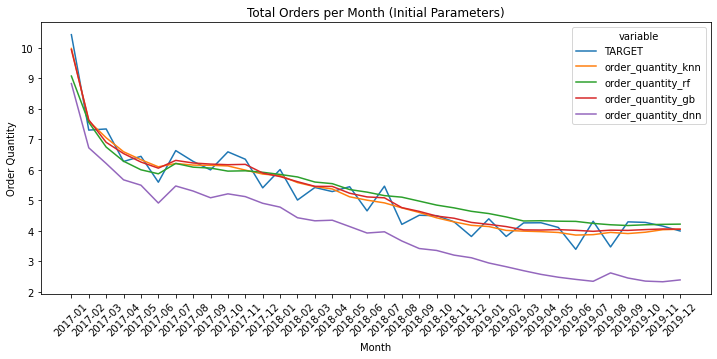

In [156]:
plt.figure(figsize=(12,5))
fig = sns.lineplot(data=monthly_orders_per_model,x='period_str',y='value',hue='variable')
fig.set_title('Total Orders per Month (Initial Parameters)')
fig.set_xlabel('Month')
fig.set_ylabel('Order Quantity')
fig.set_xticklabels(labels=monthly_orders_per_model.period_str,rotation=45);

# 4. Comparing with Previous Work

## 4.1. SVM

In [44]:
cumulative_model_results_svm = {}
tols = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.00010]
tols = [0.00001]
for tol in tols:
    svm = LinearSVR(
              tol=tol,
              loss='squared_epsilon_insensitive',
              fit_intercept=True,
              intercept_scaling=1.0,
              dual=False,
              max_iter=100000)
    results, svm = run_kfold_model(df,svm,'SVM Regressor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_svm[str(tol)] = {'results':results,'model':svm}

  0%|          | 0/5 [00:00<?, ?it/s]

===== SVM Regressor - fold 1 =====
fitting model...
model fit!
predictions are made for train_x! 1
predictions are made for train_x! 2
predictions are made for valid_x!
execution time: 1.6677870750427246
{'execution_time': 1.6677870750427246,
 'metrics': {'mae_train': 4.219604887350045,
             'mae_valid': 3.610521533844004,
             'rmse_train': 7.416549894940554,
             'rmse_valid': 6.768480916412344},
 'preds': {'train_y_pred': array([8.19226574, 8.27212998, 7.20275476, ..., 5.61721786, 0.12010683,
       8.36339316]),
           'valid_y_pred': array([7.00514218, 5.41343538, 2.77678492, ..., 4.89595934, 0.08318247,
       9.23973873])}}
===== SVM Regressor - fold 2 =====
fitting model...
model fit!
predictions are made for train_x! 1
predictions are made for train_x! 2
predictions are made for valid_x!
execution time: 1.506180763244629
{'execution_time': 1.506180763244629,
 'metrics': {'mae_train': 4.327489803755414,
             'mae_valid': 3.6397531812608666,
 

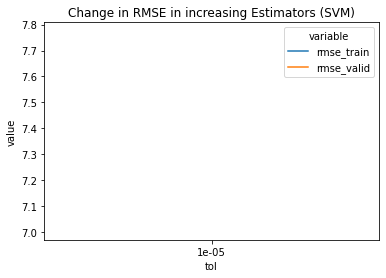

In [45]:
tols = [0.00001,0.00002,0.00003,0.00004,0.00005,0.00006,0.00007,0.00008,0.00009,0.00010]
tols = [0.00001]
x, y1, y2=[], [], []
for tol in tols:
    svm_results = get_metrics_from_results(cumulative_model_results_svm)[str(tol)]
    svm_results['avg'] = svm_results.mean(axis=1)
    x.append(tol)
    y1.append(svm_results.loc['rmse_train'].avg)
    y2.append(svm_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['tol','rmse_train','rmse_valid']
re = re.melt(id_vars=['tol'])

fig = sns.lineplot(data=re,x='tol',y='value',hue='variable')
fig.set_xticks(tols);
fig.set_xticklabels(tols);
fig.set_title('Change in RMSE in increasing Estimators (SVM)');

In [46]:
svm_results = get_metrics_from_results(cumulative_model_results_svm)[str(0.00001)]
svm_results['avg'] = svm_results.mean(axis=1)
svm_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.416550,7.546724,7.743978,7.944773,8.200194,7.770444
mae_train,4.219605,4.327490,4.498295,4.663637,4.869179,4.515641
rmse_valid,6.768481,6.803502,6.787505,7.190507,7.494893,7.008978
mae_valid,3.610522,3.639753,3.691825,3.952011,4.202671,3.819357


## 4.2. MLP

In [ ]:
from sknn.mlp import Regressor as SKNNRegressor

In [ ]:
from sklearn.neural_network import MLPRegressor

In [ ]:
import time

In [ ]:
cumulative_model_results_mlp = {}
layer_sizes = [
    (100,), # 1 layer
    (100,100,), # 2 layers
    (100,100,100,), # 3 layers
    (200,), # 1 layer
    (200,100,), # 2 layers
    (200,100,100,) # 3 layers
]
for layer_size in layer_sizes:
    # Model with following parameters:
    mlp = MLPRegressor(
        hidden_layer_sizes=layer_size,
        activation='relu',
        solver='adam',
        alpha=0.0001,
        batch_size='auto',
        learning_rate='constant',
        learning_rate_init=0.001,
        power_t=0.5,
        max_iter=600,
        shuffle=True,
        momentum=0.9,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        n_iter_no_change=10,
        max_fun=15000)
    results, mlp = run_kfold_model(df,mlp,'MLP Regressor',final_features,ix,folds=[1,2,3,4,5])
    cumulative_model_results_mlp["-".join([str(e) for e in layer_size])] = {'results':results,'model':mlp}

In [ ]:
cumulative_model_results_mlp

In [ ]:
# max_iters = [200,400,600,800,1000]
x, y1, y2=[], [], []
for layer_size in layer_sizes:
    mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["-".join([str(e) for e in layer_size])]
    mlp_results['avg'] = mlp_results.mean(axis=1)
    x.append("-".join([str(e) for e in layer_size]))
    y1.append(mlp_results.loc['rmse_train'].avg)
    y2.append(mlp_results.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['max_iter','rmse_train','rmse_valid']
re = re.melt(id_vars=['max_iter'])

fig = sns.lineplot(data=re,x='max_iter',y='value',hue='variable')
fig.set_xticks(["-".join([str(e) for e in layer_size]) for layer_size in layer_sizes]);
fig.set_xticklabels(["-".join([str(e) for e in layer_size]) for layer_size in layer_sizes]);
fig.set_title('Change in RMSE in increasing Estimators (MLP)');

### Hidden layers = 1 (100 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["100"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

### Hidden layers = 2 (100-100 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["100-100"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

### Hidden layers = 3 (100-100-100 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["100-100-100"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

### Hidden layers = 1 (200 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["200"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

### Hidden layers = 2 (200-100 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["200-100"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

### Hidden layers = 3 (200-100-100 neurons)

In [ ]:
mlp_results = get_metrics_from_results(cumulative_model_results_mlp)["200-100-100"]
mlp_results['avg'] = mlp_results.mean(axis=1)
mlp_results

# Dropout Model in Keras

In [27]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [23]:
tf.__version__

'2.7.0'

### The Normalization layer

In [28]:
normalizer = tf.keras.layers.Normalization(axis=-1)

In [29]:
normalizer.adapt(np.array(df[final_features]))

2021-12-06 20:00:18.435136: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [30]:
first = np.array(df[final_features][:1])

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first).numpy())

First example: [[15.   15.   15.   15.   15.   15.    5.55  3.82 45.    5.42  4.38  3.
   0.    1.    1.    0.    0.    0.    0.    0.    1.    0.61]]

Normalized: [[ 0.43  0.36  0.3   0.26  0.22  0.19 -0.   -0.06  0.42 -0.01 -0.06  0.61
  -0.31 -0.68  0.56 -0.25 -0.21 -0.27 -0.28 -1.52 -1.83 -0.62]]


In [27]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10)
# ])

In [31]:
from tensorflow.keras.optimizers import SGD, Adam

In [1]:
def build_and_compile_model(norm):
    model = keras.Sequential([
      norm,
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_error',
                  # optimizer=SGD(learning_rate=0.0001,decay=1e-4),
                  optimizer=Adam(learning_rate=0.001)
                 )
    return model

In [2]:
dnn = build_and_compile_model(normalizer)

NameError: name 'normalizer' is not defined

In [34]:
dnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 22)               45        
 n)                                                              
                                                                 
 dense (Dense)               (None, 128)               2944      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 13,358
Trainable params: 13,313
Non-trainable params: 45
___________________________________________________

In [32]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

In [36]:
test_results = {}

In [37]:
# model = tf.keras.models.Sequential([
#   tf.keras.layers.Flatten(input_shape=(28, 28)),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dropout(0.2),
#   tf.keras.layers.Dense(10)
# ])

In [37]:
cumulative_model_results_dnn = {}

In [102]:
results, dnn = run_kfold_model(df,dnn,'DNN',final_features,ix,folds=[1,2,3,4,5])

  0%|          | 0/5 [00:00<?, ?it/s]

===== DNN - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 288.0333080291748
{'execution_time': 288.0333080291748,
 'metrics': {'mae_train': 2.961794616057643,
             'mae_valid': 3.6587392785999504,
             'rmse_train': 5.392838207025878,
             'rmse_valid': 8.064903692598758},
 'preds': {'train_y_pred': array([6.5183454e+00, 8.1305885e+00, 1.9456060e+01, ..., 3.3589470e+00,
       1.0038196e-03, 6.2249999e+00], dtype=float32),
           'valid_y_pred': array([3.2712111e+00, 3.2194912e+00, 1.0038196e-03, ..., 3.3939958e+00,
       1.0038196e-03, 6.2175326e+00], dtype=float32)}}
===== DNN - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 239.23939514160156
{'execution_time': 239.23939514160156,
 'metrics': {'mae_train': 2.9117061609958754,
             'mae_valid': 3.1506939374274223,
             'rmse_train': 5.

In [43]:
results, dnn = run_kfold_model(df,dnn,'DNN',final_features,ix,folds=[1,2,3,4,5])

  0%|          | 0/5 [00:00<?, ?it/s]

===== DNN - fold 1 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 292.3409421443939
{'execution_time': 292.3409421443939,
 'metrics': {'mae_train': 3.0610958543716404,
             'mae_valid': 3.5553999986874407,
             'rmse_train': 5.641297701529376,
             'rmse_valid': 7.6430603613093595},
 'preds': {'train_y_pred': array([[6.4779687e+00],
       [8.2612457e+00],
       [1.1652329e+01],
       ...,
       [5.1310177e+00],
       [7.0871378e-05],
       [6.0325565e+00]], dtype=float32),
           'valid_y_pred': array([[2.9486990e+00],
       [2.9317961e+00],
       [7.0871378e-05],
       ...,
       [3.2761395e+00],
       [7.0871378e-05],
       [6.0206070e+00]], dtype=float32)}}
===== DNN - fold 2 =====
fitting model...
model fit!
predictions are made for train_x!
predictions are made for valid_x!
execution time: 241.16722989082336
{'execution_time': 241.16722989082336,
 'metrics': {'mae_train':

In [103]:
cumulative_model_results_dnn["3-layer-128-64-32-001lr-adam-100epoch-real"] = {'results':results,'model':dnn}

In [104]:
dnn_metrics = get_metrics_from_results(cumulative_model_results_dnn)

In [28]:
np.mean([7.239345,  7.070802,  6.858544,  6.915110,  7.134350])


7.0436302

In [29]:
np.mean([7.226341,  7.229401,  7.327400, 7.410854, 7.475778])

7.333954800000001

In [59]:
dnn_metrics # 1st one is picked

{'3-layer-10-dropout-both-layers-001lr-1e-6decay':               fold_1    fold_2    fold_3    fold_4    fold_5
 rmse_train  7.226341  7.229401  7.327400  7.410854  7.475778
 mae_train   3.712249  3.753140  3.857687  3.963913  4.080383
 rmse_valid  7.239345  7.070802  6.858544  6.915110  7.134350
 mae_valid   3.406501  3.338190  3.297315  3.496091  3.700478,
 '3-layer-10-dropout-both-layers-001lr-1e-3decay':               fold_1    fold_2    fold_3    fold_4    fold_5
 rmse_train  7.597490  7.690460  7.869956  8.065140  8.332822
 mae_train   3.864892  3.954327  4.109841  4.276128  4.494999
 rmse_valid  7.041046  7.051936  6.926396  7.293318  7.517925
 mae_valid   3.430408  3.411289  3.364448  3.640809  3.856434}

In [121]:
dnn_metrics

{'1-layer':               fold_1    fold_2    fold_3    fold_4    fold_5       avg
 rmse_train  7.548535  7.570503  7.779212  7.733104  7.898161  7.705903
 mae_train   3.846633  3.924514  4.064992  4.189988  4.363204  4.077866
 rmse_valid  7.163109  7.016884  6.932048  7.118979  7.308528  7.107910
 mae_valid   3.446792  3.419662  3.374304  3.626396  3.835416  3.540514,
 '2-layer':               fold_1    fold_2    fold_3    fold_4    fold_5       avg
 rmse_train  7.057325  6.749162  6.705568  6.632269  6.652721  6.759409
 mae_train   3.616699  3.573135  3.642348  3.637850  3.692294  3.632465
 rmse_valid  7.073248  6.867192  6.644702  6.711167  6.602711  6.779804
 mae_valid   3.400076  3.316022  3.289300  3.482573  3.621643  3.421923,
 '2-layer-30-dropout':               fold_1    fold_2    fold_3    fold_4    fold_5       avg
 rmse_train  7.152646  7.146064  7.157558  7.345035  7.392471  7.238755
 mae_train   3.647635  3.695601  3.770521  3.904452  3.994359  3.802513
 rmse_valid  7.129

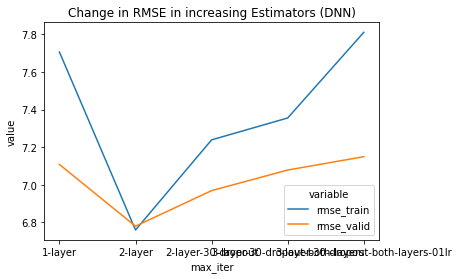

In [117]:
# max_iters = [200,400,600,800,1000]
x, y1, y2=[], [], []
for key in cumulative_model_results_dnn.keys():
    res = dnn_metrics[key]
    res['avg'] = res.mean(axis=1)
    x.append(key)
    y1.append(res.loc['rmse_train'].avg)
    y2.append(res.loc['rmse_valid'].avg)
    
re = pd.DataFrame([x,y1,y2]).T
re.columns=['max_iter','rmse_train','rmse_valid']
re = re.melt(id_vars=['max_iter'])

fig = sns.lineplot(data=re,x='max_iter',y='value',hue='variable')
fig.set_xticks(list(cumulative_model_results_dnn.keys()));
fig.set_xticklabels(list(cumulative_model_results_dnn.keys()));
fig.set_title('Change in RMSE in increasing Estimators (DNN)');

## 1 Layer DNN with Normalization Layer (0.001 LR)  # Picked

In [118]:
dnn_results = dnn_metrics["1-layer"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.548535,7.570503,7.779212,7.733104,7.898161,7.705903
mae_train,3.846633,3.924514,4.064992,4.189988,4.363204,4.077866
rmse_valid,7.163109,7.016884,6.932048,7.118979,7.308528,7.107910
mae_valid,3.446792,3.419662,3.374304,3.626396,3.835416,3.540514


## 2 Layers DNN with Normalization Layer (0.001 LR) # Picked

In [119]:
dnn_results = dnn_metrics["2-layer"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.057325,6.749162,6.705568,6.632269,6.652721,6.759409
mae_train,3.616699,3.573135,3.642348,3.637850,3.692294,3.632465
rmse_valid,7.073248,6.867192,6.644702,6.711167,6.602711,6.779804
mae_valid,3.400076,3.316022,3.289300,3.482573,3.621643,3.421923


## 2 Layers DNN with Normalization Layer and 30% Dropout Layer (0.001 LR) 

In [124]:
dnn_results = dnn_metrics["2-layer-30-dropout"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.152646,7.146064,7.157558,7.345035,7.392471,7.238755
mae_train,3.647635,3.695601,3.770521,3.904452,3.994359,3.802513
rmse_valid,7.129823,6.964140,6.767688,6.929495,7.053240,6.968877
mae_valid,3.389194,3.304390,3.298746,3.491899,3.706484,3.438143


## 3 Layers DNN with Normalization Layer and 2, 30% Dropout Layers (0.001 LR)  # Picked

In [125]:
dnn_results = dnn_metrics['3-layer-30-dropout-both-layers']
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.202084,7.344041,7.172268,7.612356,7.444531,7.355056
mae_train,3.665793,3.758069,3.771411,3.972845,4.016278,3.836879
rmse_valid,7.223297,7.168309,6.748103,7.120961,7.130346,7.078203
mae_valid,3.389618,3.355659,3.256824,3.522078,3.673413,3.439518


## 3 Layers DNN with Normalization Layer and 2, 30% Dropout Layers (0.01 LR) 

In [126]:
dnn_results = dnn_metrics['3-layer-30-dropout-both-layers-01lr']
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,7.697384,7.429786,7.843328,7.896757,8.184619,7.810375
mae_train,4.041172,4.044938,4.228258,4.320448,4.439757,4.214915
rmse_valid,7.222504,6.983207,6.853210,7.148851,7.538512,7.149257
mae_valid,3.546904,3.556886,3.559954,3.887499,4.063417,3.722932


## 3 Layers 128-64-32 Adam DNN with Normalization Layer and without Dropout Layers (0.001 LR) - epoch = 40

In [61]:
dnn_results = dnn_metrics["3-layer-128-64-32-001lr-adam"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.851550,6.509348,6.358763,6.196867,6.142361,6.411778
mae_train,3.527665,3.430017,3.433826,3.423286,3.434286,3.449816
rmse_valid,7.199547,7.019065,6.498951,6.468315,6.561209,6.749417
mae_valid,3.422680,3.298017,3.174672,3.337750,3.507932,3.348210


## 3 Layers 128-64-32 Adam DNN with Normalization Layer and without Dropout Layers (0.001 LR) - epoch = 60

In [70]:
dnn_results = dnn_metrics["3-layer-128-64-32-001lr-adam-60epoch"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.696422,6.242470,6.079383,5.942259,5.807177,6.153542
mae_train,3.457756,3.349368,3.332966,3.315473,3.286109,3.348335
rmse_valid,7.334213,6.931965,6.474511,6.402473,6.288494,6.686331
mae_valid,3.455768,3.282385,3.192223,3.289467,3.434700,3.330908


## 3 Layers 128-64-32 Adam DNN with Normalization Layer and without Dropout Layers (0.001 LR) - epoch = 80

In [41]:
dnn_results = dnn_metrics["3-layer-128-64-32-001lr-adam-80epoch"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,6.451532,6.027818,5.838032,5.722850,5.580009,5.924048
mae_train,3.379321,3.252734,3.229105,3.212877,3.161109,3.247029
rmse_valid,7.458313,6.849654,6.367288,6.232669,6.224180,6.626421
mae_valid,3.485628,3.273367,3.143349,3.287861,3.424148,3.322870


## 3 Layers 128-64-32 Adam DNN with Normalization Layer and without Dropout Layers (0.001 LR) - epoch = 100

In [95]:
dnn_results = dnn_metrics["3-layer-128-64-32-001lr-adam-100epoch"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,5.641298,5.459304,5.345335,5.327337,5.273727,5.409400
mae_train,3.061096,3.030197,3.008433,3.032729,2.989557,3.024402
rmse_valid,7.643060,6.598053,5.908013,5.697384,5.763033,6.321909
mae_valid,3.555400,3.199028,3.018756,3.112150,3.221278,3.221323


## 3 Layers 128-64-32 Adam DNN with Normalization Layer and without Dropout Layers (0.001 LR) - epoch = 100 real

In [106]:
dnn_results = dnn_metrics["3-layer-128-64-32-001lr-adam-100epoch-real"]
dnn_results['avg'] = dnn_results.mean(axis=1)
dnn_results

,fold_1,fold_2,fold_3,fold_4,fold_5,avg
rmse_train,5.392838,5.216586,5.130025,5.165229,5.132622,5.207460
mae_train,2.961795,2.911706,2.911250,2.924052,2.921677,2.926096
rmse_valid,8.064904,6.403963,5.727176,5.489627,5.587042,6.254542
mae_valid,3.658739,3.150694,2.958330,3.038814,3.129869,3.187289
